In [ ]:
# pip install prophet

In [1]:
import pandas as pd
import numpy as np

from prophet import Prophet


congestion = pd.read_csv('/Users/gabrielmedeiros/Desktop/Data_Science_Competitions/Comp1/train.csv')
test_data = pd.read_csv('/Users/gabrielmedeiros/Desktop/Data_Science_Competitions/Comp1/test.csv')

congestion.head()

Importing plotly failed. Interactive plots will not work.


,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [ ]:
# congestion['time'] = pd.to_datetime(congestion['time'])

# congestion['month_name'] = congestion['time'].dt.month_name()

# congestion['month'] = congestion['time'].dt.month

# congestion['day_name'] = congestion['time'].dt.day_name()

# congestion['day'] = congestion['time'].dt.day

# congestion['hour'] = congestion['time'].dt.hour

# congestion['minute'] = congestion['time'].dt.minute

# congestion = congestion.drop(columns = ['time','row_id'])

# congestion = pd.get_dummies(congestion, columns = ['month_name', 'day_name', 'direction'])

# congestion.head()

In [2]:
congestion['location_id'] = pd.DataFrame(
                 'x' + congestion.x.astype(str) +\
                 'y' + congestion.y.astype(str) + \
                 congestion.direction.astype(str))

train_prophet = congestion[['location_id', 'time' ,'congestion']]
train_prophet.columns = ['location_id','ds','y']
train_prophet.tail()                                 

,location_id,ds,y
848830,x2y3NB,1991-09-30 11:40:00,54
848831,x2y3NE,1991-09-30 11:40:00,28
848832,x2y3SB,1991-09-30 11:40:00,68
848833,x2y3SW,1991-09-30 11:40:00,17
848834,x2y3WB,1991-09-30 11:40:00,24


In [3]:
test_data['location_id'] = pd.DataFrame(
                 'x' + congestion.x.astype(str) +\
                 'y' + congestion.y.astype(str) + \
                 congestion.direction.astype(str))

test_prophet = test_data[['location_id', 'time']]
test_prophet.columns = ['location_id','ds']
test_prophet.tail()

,location_id,ds
2335,x2y3NB,1991-09-30 23:40:00
2336,x2y3NE,1991-09-30 23:40:00
2337,x2y3SB,1991-09-30 23:40:00
2338,x2y3SW,1991-09-30 23:40:00
2339,x2y3WB,1991-09-30 23:40:00


In [11]:
future = pd.DataFrame(test_prophet['ds'][test_prophet['location_id'] == 'x2y3NE'].reset_index(drop = True))

In [27]:
results = pd.DataFrame()

from tqdm import tqdm

locations = train_prophet.groupby('location_id')

for g in tqdm(locations.groups):
    
    group_train = locations.get_group(g)
    
    prophet_md = Prophet()
    prophet_fit = prophet_md.fit(group_train)
    
    forecast = prophet_fit.predict(future)
    forecast['location'] = g
    #I used concat instead of merge
    results = pd.concat([results, forecast], ignore_index=True)

results.head(10)

100%|██████████| 65/65 [02:44<00:00,  2.52s/it]


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,location
0,1991-09-30 12:00:00,48.293995,33.511300,65.110371,48.293995,48.293995,0.650644,0.650644,0.650644,0.129876,0.129876,0.129876,0.520768,0.520768,0.520768,0.0,0.0,0.0,48.944639,x0y0EB
1,1991-09-30 12:20:00,48.294042,33.643594,63.501946,48.294042,48.294042,0.828168,0.828168,0.828168,0.224697,0.224697,0.224697,0.603471,0.603471,0.603471,0.0,0.0,0.0,49.122210,x0y0EB
2,1991-09-30 12:40:00,48.294089,34.322478,64.356438,48.294089,48.294089,1.202883,1.202883,1.202883,0.518072,0.518072,0.518072,0.684811,0.684811,0.684811,0.0,0.0,0.0,49.496971,x0y0EB
3,1991-09-30 13:00:00,48.294136,35.133562,64.939323,48.294136,48.294136,1.754404,1.754404,1.754404,0.989672,0.989672,0.989672,0.764732,0.764732,0.764732,0.0,0.0,0.0,50.048539,x0y0EB
4,1991-09-30 13:20:00,48.294182,34.940214,67.016668,48.294182,48.294182,2.437503,2.437503,2.437503,1.594322,1.594322,1.594322,0.843181,0.843181,0.843181,0.0,0.0,0.0,50.731685,x0y0EB
5,1991-09-30 13:40:00,48.294229,35.460397,66.387244,48.294229,48.294229,3.187951,3.187951,3.187951,2.267845,2.267845,2.267845,0.920106,0.920106,0.920106,0.0,0.0,0.0,51.482180,x0y0EB
6,1991-09-30 14:00:00,48.294276,37.745792,68.018581,48.294276,48.294276,3.930798,3.930798,3.930798,2.935343,2.935343,2.935343,0.995456,0.995456,0.995456,0.0,0.0,0.0,52.225075,x0y0EB
7,1991-09-30 14:20:00,48.294323,37.696492,68.808870,48.294323,48.294323,4.590009,4.590009,4.590009,3.520826,3.520826,3.520826,1.069183,1.069183,1.069183,0.0,0.0,0.0,52.884332,x0y0EB
8,1991-09-30 14:40:00,48.294370,37.340846,69.442520,48.294370,48.294370,5.098218,5.098218,5.098218,3.956976,3.956976,3.956976,1.141242,1.141242,1.141242,0.0,0.0,0.0,53.392589,x0y0EB
9,1991-09-30 15:00:00,48.294417,38.437948,67.892284,48.294417,48.294417,5.405355,5.405355,5.405355,4.193767,4.193767,4.193767,1.211588,1.211588,1.211588,0.0,0.0,0.0,53.699772,x0y0EB


In [30]:
results.shape

(2340, 20)

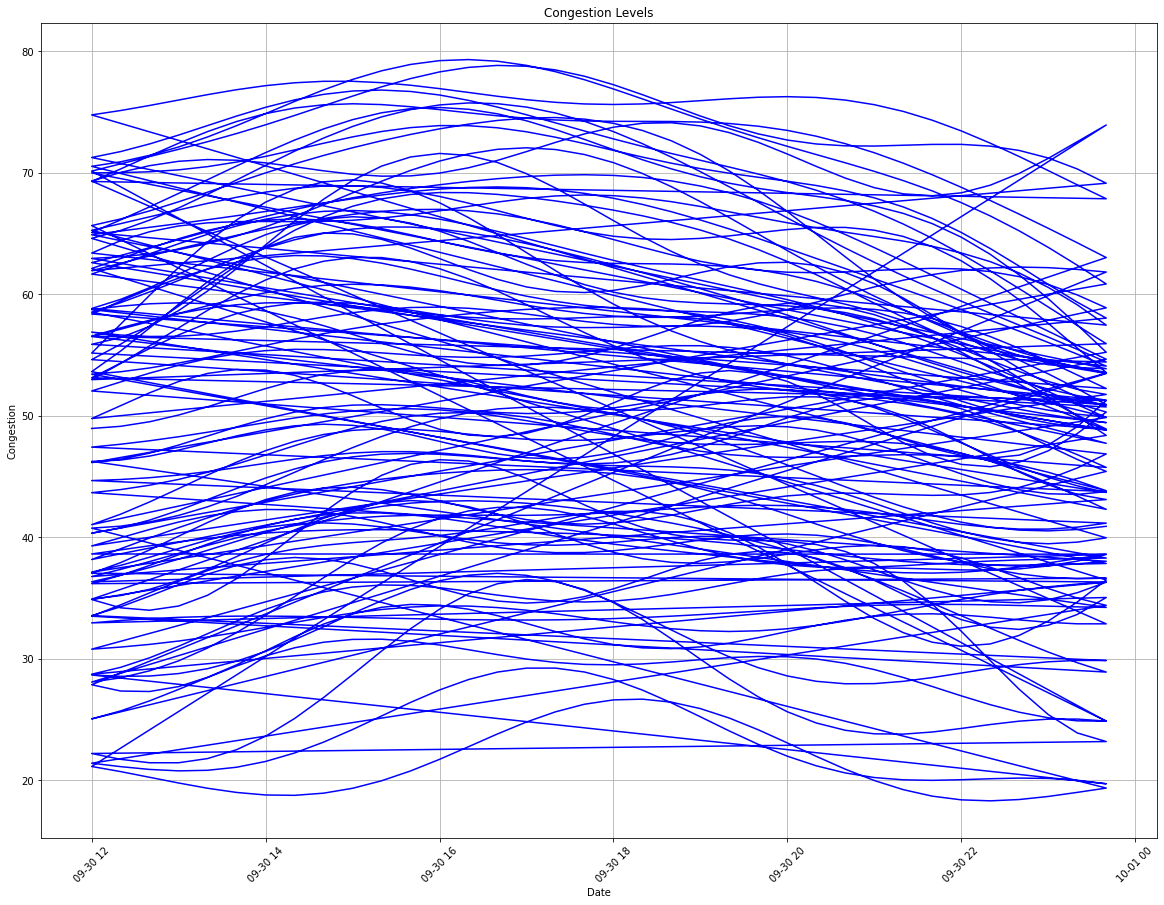

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,15))
plt.plot(results.ds, results.yhat, color = 'blue')
# plt.plot(results.ds, results.yhat_upper, color = 'red')
# plt.plot(results.ds, results.yhat_lower, color = 'red')
plt.title('Congestion Levels')
plt.xlabel('Date')
plt.ylabel('Congestion')
plt.xticks(rotation = 45)
plt.grid()
plt.show()

## Saving a prophet model and loading using json

In [ ]:

# import json
# from prophet.serialize import model_to_json, model_from_json

# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)  # Save model

# with open('serialized_model.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model

## Hyperparameter tuning

In [28]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
from tqdm import tqdm

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
    m = Prophet(**params).fit(validation)  # Fit model with given params
    df_cv = cross_validation(m, horizon = '19 min',parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

  0%|          | 0/16 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/16 [00:00<?, ?it/s]


ValueError: Less data than horizon after initial window. Make horizon or initial shorter.

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)